In [23]:
import math
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit import QuantumCircuit, QuantumRegister, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, PhaseEstimation
from IPython.display import display,Latex



Como ya vimos en el capítulo anterior, la implementación de este algoritmo depende de poder implementar el operador:
    
    U|y> = |xy (mod N)>.
    
Supongamos que queremos calcular el orden de 7 mod 15. Sabemos de antemano que 7^4 mod 15 = 1, de manera que el orden es 3. 15 se puede escribir con 4 bits. De manera que empezamos por definir que el circuito que realiza la operación x -> x7^j mod 15 y las variables asociadas al circuito.

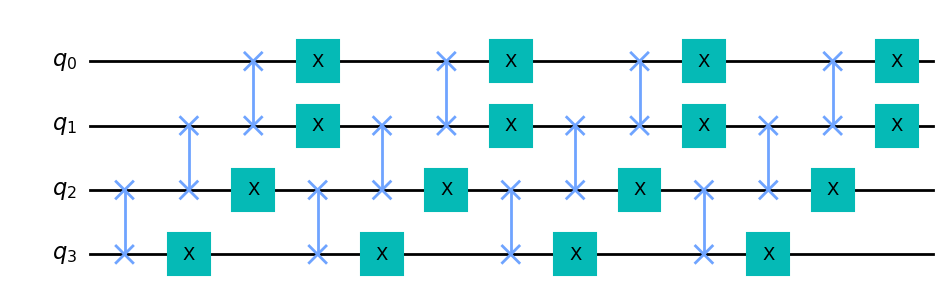

In [14]:
def calcular_operador_elevado_a_potencia(j):
    U_alt = QuantumCircuit(4,name="U^(2^"+str(j)+")")
    for i in range(2**j):
        U_alt.swap(2,3)
        U_alt.swap(1,2)
        U_alt.swap(0,1)
        for k in range(4):
            U_alt.x(k)
    return U_alt
calcular_operador_elevado_a_potencia(2).draw('mpl')

In [18]:
N = 15
eps = 0.05
x = 7

truncated_value = math.trunc(math.log2(N))
exact_value_log = math.log2(N)
L = truncated_value
if (truncated_value - exact_value_log != 0):
    L = L + 1
    
truncated_value = 2*L + math.trunc(math.log(2+1/(2*eps)))
exact_value_log = 2*L + math.log(2+1/(2*eps))
                                 
t = L + int( math.trunc(math.log(2+1/(2*eps)))) -1

if (truncated_value - exact_value_log != 0):
    t = t + 1

print(t,L)

6 4


In [19]:
def circuito_estimacion_fase(t,L,N,x):
    phase_circ = QuantumCircuit(t+L,t)

    
    phase_circ.x(0)
    for i in range(L,t+L):
        phase_circ.h(i)

    for i in range(t):
        #cond_operator_U = exponenciar(U,2**i)
        #partial_circ = QuantumCircuit(L, name="U^(2^"+str(i)+")")
        #partial_circ.append(Operator(cond_operator_U),[i for i in range(L)])
        phase_circ.append(calcular_operador_elevado_a_potencia(i).to_gate().control(1),[L+i]+[i for i in range(L)])

    phase_circ.append(QFT(num_qubits=t, approximation_degree=0, do_swaps=True, inverse=True, insert_barriers=False, name=None),[i for i in range(L,t+L)])

    for i in range(t):
        phase_circ.measure(L+i,i)

    return phase_circ

Ahora solo tenemos que aplicar el algoritmo de estimación de fase con el operador U calculado anteriormente

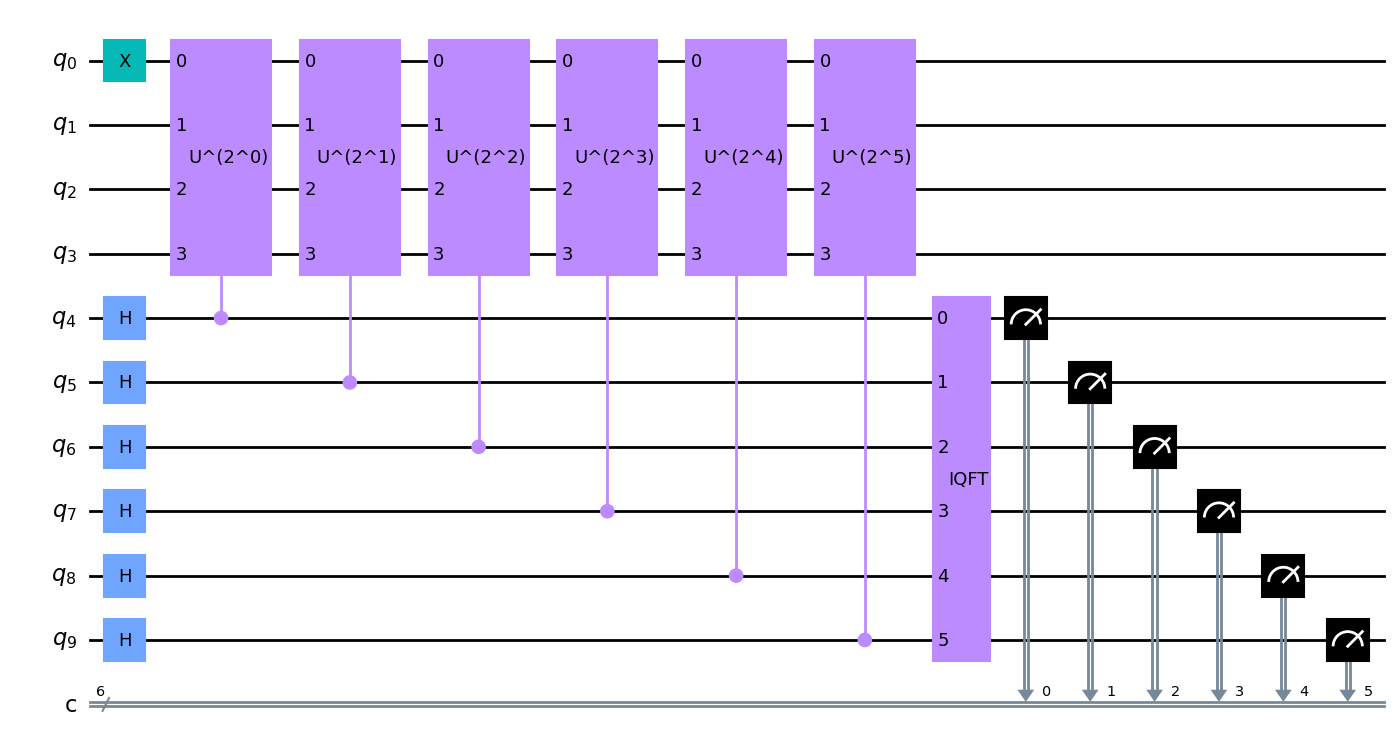

In [20]:
circ = circuito_estimacion_fase(t,L,N,x)
circ.draw('mpl')

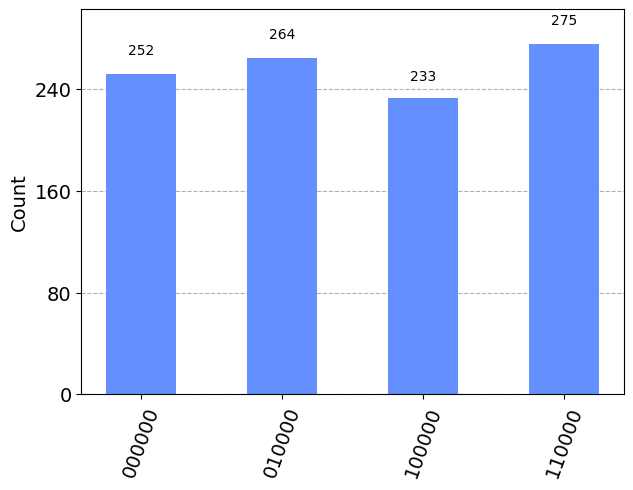

In [21]:
#Procedemos a compilar el circuito y ejecutarlo:
simulator = AerSimulator()
circuit_compiled = transpile(circ,simulator)
trabajo_sim = simulator.run(circuit_compiled, shots = 1024)
result = trabajo_sim.result()
counts = result.get_counts(circuit_compiled)

plot_histogram(counts)

Aquí podemos ver como los resultados son 0,1/2,3/4 y 1/4. Como 1/2 = 2/4 es fácil concluir que el orden buscado es 4, que es justamente lo que habíamos calculado previamente. 